# Técnicas de Construção da ETTJ

A <b>interpolação</b> e os modelos de curvas, como o <b>Nelson-Siegel-Svensson (NSS)</b>, são duas técnicas amplamente utilizadas na construção de uma Estrutura a Termo de Taxas de Juros (ETTJ). Cada uma possui características distintas, com vantagens e desvantagens específicas. Vamos explorar cada uma delas:

- <b>Interpolação:</b>
    A interpolação é uma técnica que permite estimar taxas de juros para prazos de vencimento intermediários com base nos dados observados disponíveis. Existem diferentes métodos de interpolação, como polinômios de Lagrange, spline cúbica, interpolação linear, entre outros. As vantagens da interpolação incluem a simplicidade de implementação e a capacidade de fornecer estimativas suaves e contínuas da ETTJ. No entanto, a interpolação não leva em consideração a estrutura subjacente das taxas de juros e pode não capturar com precisão as mudanças na forma da curva.
    
    A interpolação, por ser mais simples de se implementar, acaba sendo amplamente utilizada, e tem também a vantagem de conseguir exprimir exatamente o valor do ponto, nos pontos onde temos dados. Aqui, vamos estudar esta técnica por ser poderosa e ao mesmo tempo palatável para a compreensão deste conceito.

- <b>Modelos de Curvas (NSS):</b>
    Os modelos de curvas, como o Nelson-Siegel-Svensson, são abordagens paramétricas que visam capturar a estrutura da ETTJ com base em uma equação matemática. O NSS utiliza uma combinação linear de funções exponenciais decrescentes para representar a curva de juros. As vantagens desses modelos incluem a flexibilidade para ajustar diferentes formatos da curva, como inclinação e convexidade, e a capacidade de extrapolação além dos prazos de vencimento observados. No entanto, esses modelos requerem estimativas de parâmetros e podem ser sensíveis a escolhas específicas de parâmetros, além de serem limitados pela suposição subjacente da forma funcional da curva.
    
    Os modelos de curvas acabam sendo mais complexos. A ANBIMA tem um documento técnico interessante onde ela explica a técnica que ela utiliza para calcular a ETTJ. neste caso, a ANBIMA utiliza um modelo de NSS utilizando algoritmo genético para calibrar os parâmetros. Não veremos detalhadamente esta técnica aqui por ela ser mais complexa e necessitar do conhecimento de outras ferramentas matemáticas mais avançadas, como otimização por exemplo.

## Interpolação

Vimos que a ETTJ nos permite precificar títulos com diferentes características. Entretanto, temos um problema prático: não conseguimos observar preços de títulos *zero-coupon* para todos os vencimentos possíveis. Observamos apenas alguns pontos da curva, que chamamos de **vértices**. Os demais pontos não são diretamente observáveis no mercado. Para resovler isso, lançamos mão de métodos para completar esses "buracos" na ETTJ.

Uma classe desses métodos envolve técnicas de **interpolação** e **extrapolação** de curvas. Nesta seção, vamos analisar as técnicas mais utilizadas no mercado:

- Linear
- *Flat forward*
- *Cubic spline*

É importante destacar que sempre haverá certa arbitrariedade na seleção da técnica a ser empregada para construir a ETTJ. A escolha dependerá da situação específica em que seu uso deve ser empregado.

### Interpolação Linear

Consiste em interligar cada par de vértices por uma reta. Este método normalmente é empregado para curvas em moedas estrangeiras, tendo em vista o uso de taxas de convenção linear.

Sejam $r_a$ e $r_b$ as taxas *spot* observadas para os vencimentos $a$ e$b$, respectivamente. Se desejarmos obter a taxa interpolada $r_x$ para o prazo $x$, aplicaremos a equação:

$$ r_x = \frac{r_b - r_a}{b-a}(x-a) + r_a $$

para o caso da interpolação linear

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, date
from scipy.interpolate import interp1d, CubicSpline

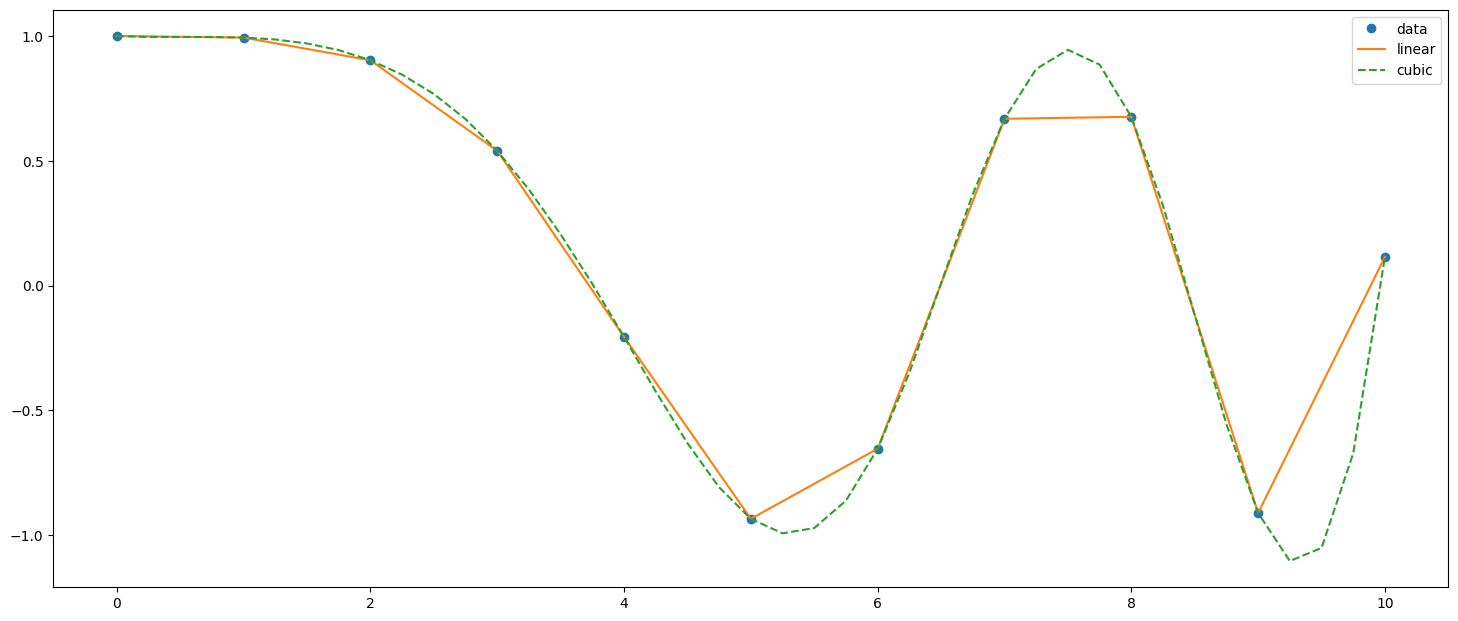

In [2]:
# exemplo de interpolação

x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(0, 10, num=41, endpoint=True)

plt.figure(figsize=(18, 7.5))
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

**Exercício 2**

Faça o gráfico da curva interpolada linearmente a partir das taxas disponibilizadas na planilha.

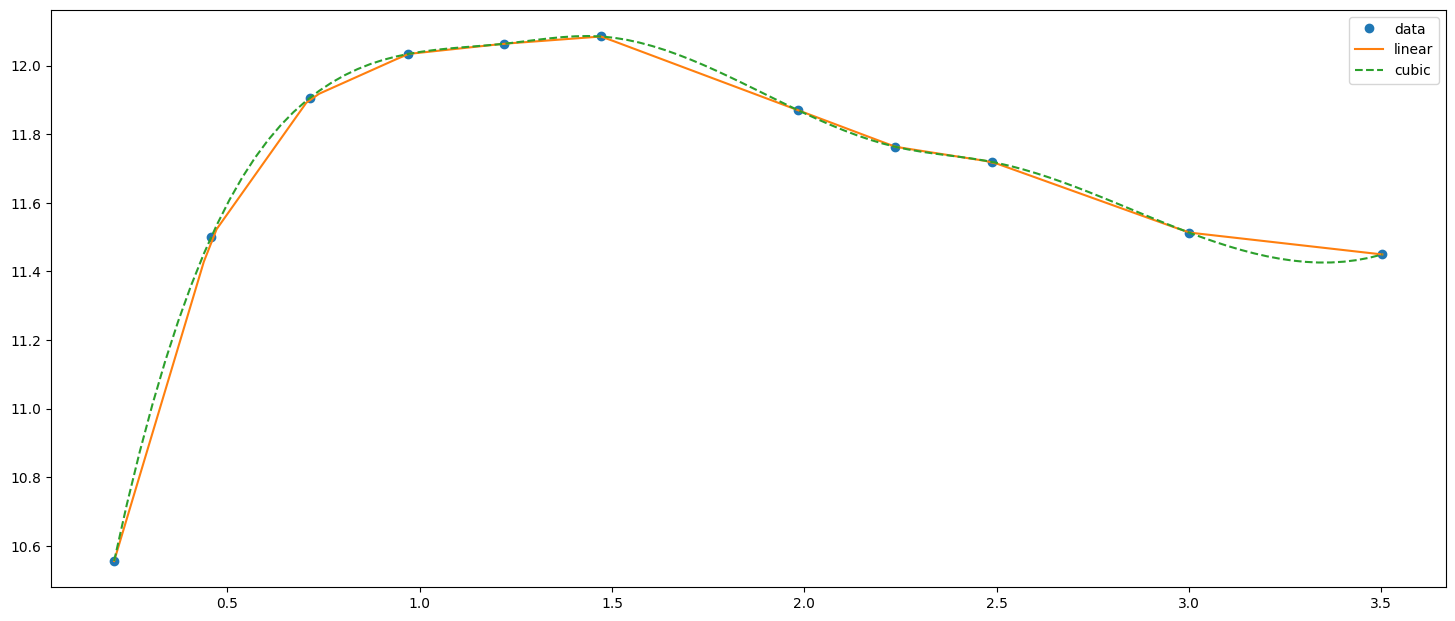

In [3]:
# data base: 17/01/2022

df = pd.read_excel('16_m22jan17.xls', sheet_name='LTN', skiprows=4, skipfooter=1, header=0, usecols=['Data de Vencimento', 'Tx. Venda'])
# print(df)

db = datetime.strptime('2022-01-17', '%Y-%m-%d')
df['prazo'] = df['Data de Vencimento'].apply(lambda x: (x - db).days/360)
x = df['prazo'].values
y = df['Tx. Venda']
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(df['prazo'].min(), df['prazo'].max(), num=100, endpoint=True)

plt.figure(figsize=(18, 7.5))
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

## xx=(dx-db).days/360
# f(xx)

**Exercício 3**

Calcule a taxa interpolada linearmente para a data 01/06/2022.

In [4]:
prazo = (date(2022,6,1) - date(2022,1,17)).days/360
taxa_prazo = f(prazo)
print(f'LTN 01/06/2022: {taxa_prazo:.2f}%')

LTN 01/06/2022: 11.19%


### Interpolação *Flat forward*

A interpolação *flat forward* consiste em aplicar uma interpolação linear ao logaritmo do fator de desconto associado a cada vértice da curva de juros.

Sejam $D_a$ e $D_b$ os fatores de desconto associados às taxas *spot* observadas para os vencimento $a$ e $b$, respectivamente. Se desejarmos obter o fator de desconto $D_x$ interpolado para o prazo $x$, aplicaremos a equação:

$$ D_x = exp\left(\frac{ln(D_b) - ln(D_a)}{b-a}(x-a) + ln(D_a)\right) $$

para o caso da interpolação *flat forward*.

A partir de $D_x$ podemos extrair a taxa *spot* interpolada para o prazo $x$ para a convenção desejada. Por exemplo, se desejarmos obter a taxa $r_x$ com convenção de taxa composta, bastará aplicar os conceitos apresentados no início desta aula, o que resula na equação:

$$ r_x = \left (\frac{1}{D_x}\right)^{\frac{1}{x}} - 1 $$


In [5]:
df

,Data de Vencimento,Tx. Venda,prazo
0,2022-04-01,10.5558,0.205556
1,2022-07-01,11.5014,0.458333
2,2022-10-01,11.9054,0.713889
3,2023-01-01,12.0337,0.969444
4,2023-04-01,12.0636,1.219444
5,2023-07-01,12.0847,1.472222
6,2024-01-01,11.8700,1.983333
7,2024-04-01,11.7634,2.236111
8,2024-07-01,11.7189,2.488889
9,2025-01-01,11.5133,3.000000


**Exercício 4**

Calcule a taxa interpolada *flat forward* para a data 01/06/2022.

In [6]:
a = df.iloc[0]['prazo']
Da = 1/(1 + df.iloc[0]['Tx. Venda'])**a

b = df.iloc[1]['prazo']
Db = 1/(1 + df.iloc[1]['Tx. Venda'])**b

xis = (date(2022,6,1) - date(2022,1,17)).days

Dx = np.exp((np.log(Da) - np.log(Db))/(a - b)*(xis - b) + np.log(Db))

rx = (1/Dx)**(1/xis) - 1
print(f'LTN 01/06/2022: {rx:.2f}%')

LTN 01/06/2022: 12.32%


### Interpolação *Cubic Spline*

O *spline* é um conjunto de polinômios de baixo grau, unidos em vértices, formando uma função contínua em um intervalo. Para que haja uma solução bem definida com certo grau de suavidade, costumam-se impor limites sobre os vértices. Esse método foi desenvolvido inicialmente para resolver interpolação de funções suaves, já que reduz as instabilidades características dos polinômios de alta ordem.

O *spline* cúbico é o mais comum dentro da literatura financeira. Isto ocorre porque este é o *spline* de mais baixo grau que possibilita a criação de uma curva interpolada sem a presença de descontinuidades e que seja continuamente diferenciável.

Suponha que $r(t)$ seja uma função *spline* cúbica sobre um conjunto de $n$ vértices. Os vértices são identificados pelas taxas observadas $y_1, y_2,...,y_n$ relativas aos prazos $t_1, t_2, ..., t_n$ respectivamente. Para cada intervalo $[t_i, t_{i+1}]$, $r(t)$ deve ser igual a um polinômio cúbico dado por:

$$ P_i(t) = a_{0,i} + a_{1,i}t  + a_{2,i}t^2 + a_{3,i}t^3$$

Onde $i= 1,...,n-1$ representa cada intervalo onde é definido um polinômio.

Para determinar os polinômios $P_i$, devemos determinar $4n-4$ constantes. Cada polinômio $P_i$ deve passar pelos vértices $i$ e $i+1$. Como condições adicionais, a primeira e segunda derivadas nos vértices devem ser iguais para os polinômios que se conectam. Podemos representar estas condições por:

\begin{equation}
\left\{
\begin{array}{rll}
P_i(t_i) = y_i, & \hbox{para} & 1 \leq i \leq n-1 \\
P_i(t_{i+1}) = y_{i+1}, & \hbox{para} & 1 \leq i \leq n-1 \\
P'_i(t_{i+1}) = P'_{i+1}(t_{i+1}), & \hbox{para} & 1 \leq i \leq n-2 \\
P''_i(t_{i+1}) = P''_{i+1}(t_{i+1}), & \hbox{para} & 1 \leq i \leq n-2 \\
\end{array}
\right. 
\end{equation}

A lista de restrições acima contém um total de $4n-6$ equações. Portanto, para completar o modelo precisamos de mais 2 restrições. Para estas restrições adicionais, existem algumas possibilidades. A mais usual, chamada de *cubic spline natural*, envolve atribuir valor zero à segunda derivada do primeiro polinômio no primeiro vértice e ao último polinômio no último vértice, conforme as equações:

\begin{equation}
\left\{
\begin{array}{r}
P''_1(t_1) = 0 \\
P''_{n-1}(t_{n}) = 0
\end{array}
\right.
\end{equation}

In [7]:
print(x)
print()
print(y)

[0.20555556 0.45833333 0.71388889 0.96944444 1.21944444 1.47222222
 1.98333333 2.23611111 2.48888889 3.         3.50277778]

0     10.5558
1     11.5014
2     11.9054
3     12.0337
4     12.0636
5     12.0847
6     11.8700
7     11.7634
8     11.7189
9     11.5133
10    11.4494
Name: Tx. Venda, dtype: float64


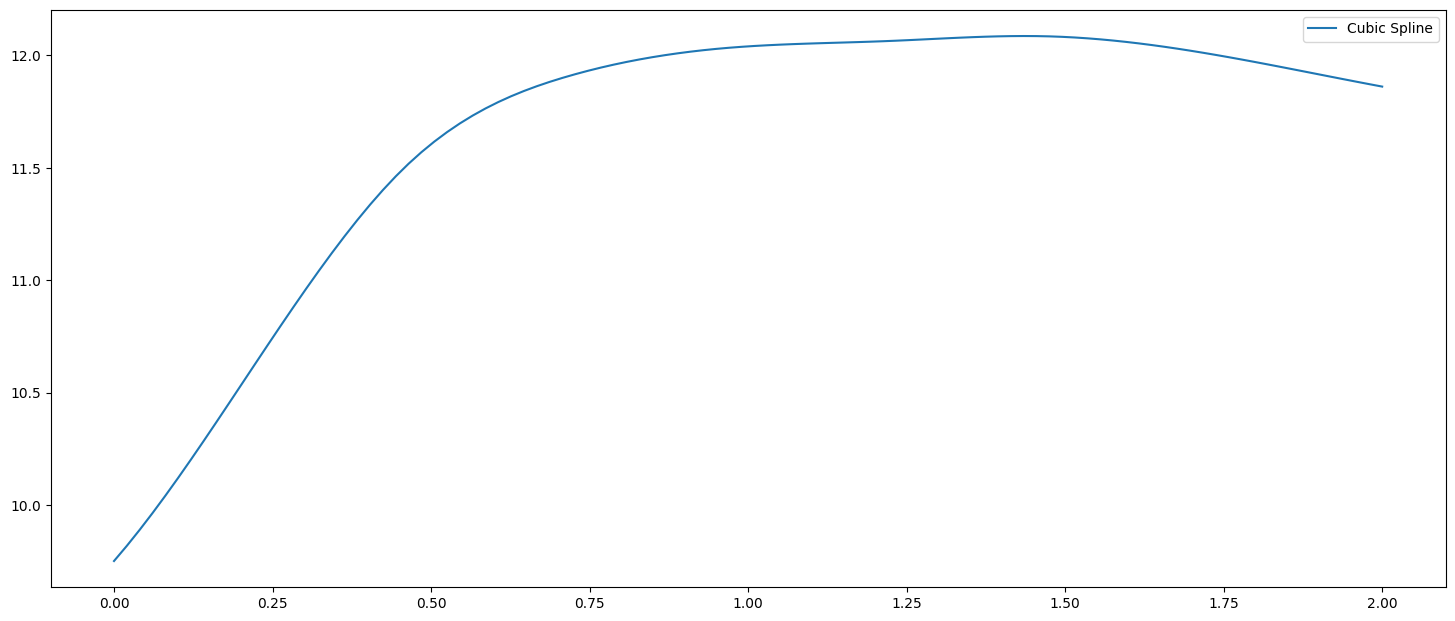

In [11]:
f = CubicSpline(x, y, bc_type='natural')
x_new = np.linspace(0, 2, 100)
y_new = f(x_new)

plt.figure(figsize=(18, 7.5))
plt.plot(x_new, y_new, label='Cubic Spline')
plt.legend()
plt.show()

## Modelos de ETTJ

Os modelos de curvas de juros aplicam uma única função para determinar toda a curva de juros.

Nos modelos de interpolação, a curva de juros resultante passa por todos os vértices da curva. Já na técnica de modelos de curva de juros, os parâmetros do modelo são calibrados de forma a passar o mais perto posível dos pontos observados da curva.

O modelo **Svensson** (1994) utiliza um somatório de exponenciais para modelar toda a curva de juros. Este modelo é expresso matematicamente pela equação:

\begin{equation}
r(\tau)=\beta_1 + 
\beta_2\left( \frac{1-e^{-\lambda_1 \tau}}{\lambda_1 \tau} \right) + 
\beta_3\left( \frac{1-e^{-\lambda_1 \tau}}{\lambda_1 \tau} - e^{- \lambda_1 \tau}\right) + 
\beta_4\left( \frac{1-e^{-\lambda_2 \tau}}{\lambda_2 \tau} - e^{- \lambda_2 \tau}\right)
\end{equation}

Onde $\beta_1, \beta_2, \beta_3, \beta_4, \lambda_1$ e $\lambda_2$ são as constantes do modelos, e $\tau$ é o prazo associado à taxa *spot* $r(\tau)$. A ANBIMA utiliza estes modelos para divulgar curvas de referência para as curvas de juros prefixados em reais e de cupom de IPCA.

https://www.anbima.com.br/pt_br/informar/curvas-de-juros-fechamento.htm

Outro modelo muito conhecido é o modelo **Nelson Siegel** (1987), dado pela equação:

\begin{equation}
r(\tau)=\beta_1 + 
\beta_2\left( \frac{1-e^{-\lambda \tau}}{\lambda \tau} \right) + 
\beta_3\left( \frac{1-e^{-\lambda \tau}}{\lambda \tau} - e^{- \lambda \tau}\right) 
\end{equation}

Onde $\beta_1, \beta_2, \beta_3 e \lambda$ são as constantes do modelos, e $\tau$ é o prazo associado à taxa *spot* $r(\tau)$. Podemos ver este modelo como um caso particular do Svensson, onde $\beta_4 = \lambda_2 = 0$.


## *Bootstrapping*

A construção da curva de juros de uma classe de ativos de renda fixa é derivada da cotação de mercado de tais ativos. Como mensionado anteriormente, a ETTJ é uma relação entre a taxa de cupom zero e uma maturidade.

Entretanto, diversos ativos apresentam pagamentos intermediários de cupom, e sua taxa interna de tetorno (TIR) não reflete, portanto, a taxa de cupom zero. O método utilizado para extrair uma taxa de cupom zero a partir de ativos que pagam cupons periódicos é chamado de ***bootstrapping***.

O princípio básico deste métodose apoia no fato de que um título que paga cupom em $N$ períodos pode ser decomposto em $N$ títulos de cupom zero. Caso o título mais curto não possua mais pagamento de cupom intermediário, sua taxa de retorno será uma taxa *zero-coupon* no vencimento desse título. A partir dessa taxa *zero-coupon* obtida, calcula-se a taxa *zero-coupon* no vencimento de um segundo título, cujo único pagamento intermediário ocorra na mesma data do vencimento do primeiro título. Seguindo esse método sucessivamente, é possível extrair a taxa zero cupom nos vencimentos dos respectivos cupons de juros.

**Exemplo**

A tabela a seguir mostra o vencimento e o preço unitário de quatro títulos prefixados com valor de face de R\$ 1000,00 e pagamentos de cupom semestral de 10% a.a. (padrão exponencial).

Vencimentos (meses) | PU
--------------------|---
 6| 953
 12| 996
 18|991
 24|987
 **Tabela 1** - Vencimentos e preços unitários para os títulos do exemplo.

O título com vencimento em 6 meses é zero cupom por definição e, por ser negociado ao par, sua taxa de retorno de 10% a.a. é igual à taxa zero cupom para o período de 6 meses. 

Considerando o preço unitário e o fluxo de pagamento futuro do título com vencimento em 12 meses e a taxa zero cupom para o período de 6 meses, pode-se calcular a taxa zero cupom de 12 meses $r_2$ da seguinte forma:

$$ 996 = \frac{48.8088}{(1+0.10)^{\frac{6}{12}}} +
\frac{1048.8088}{(1+r_2)^{\frac{12}{12}}}$$

Resolvendo esta equação obtemos $r_2 = 10.46\%$ a.a.

Considerando o preço untário e o fluxo de pagamento futuro do título com vencimento em 18 meses e a taxa zero cupom para o período de 6 a 12 meses, pode-se calcular a taxa zero cupom de 18 meses:

$$ 991 = \frac{48.8088}{(1+0.10)^{\frac{6}{12}}} + \frac{48.8088}{(1+0.1046)^{\frac{12}{12}}} + 
\frac{1048.8088}{(1+r_3)^{\frac{18}{12}}} $$

Resolvendo esta equação obtemos $r_3 = 10.73\%$ a.a.

Por fim, considerando o preço unitário e o fluxo de pagamento futuro do título com vencimento em 24 meses e a taxa zero cupom para os períodos de 6, 12 e 18 meses, pode-se calcular a taxa zero cupom de 24 meses da seguinte forma:

$$ 987 = \frac{48.8088}{(1+0.10)^{\frac{6}{12}}} + \frac{48.8088}{(1+0.1046)^{\frac{12}{12}}} + 
\frac{48.8088}{(1+0.1073)^{\frac{18}{12}}}  + 
\frac{1048.8088}{(1+r_4)^{\frac{24}{12}}} $$

Resolvendo esta equação obtemos $r_4 = 10.81\%$ a.a.

A tabela a seguir sumariza os resultados obtidos a partir do método *bootstrapping*:

Vencimentos (meses) | Taxa zero cupom (a.a.)
--------------------|---
  6| 10.00%
 12| 10.46%
 18| 10.73%
 24| 10.81%
 
 
 **Tabela 2** - Taxas *spot* extraídas a partir do método *bootstrapping*.

In [12]:
((1+10/100)**(1/2) - 1)*100

4.880884817015163

In [ ]:
# 10% a.a.
r1 = 10/100  
# r2 = ?
P2 = 996    # preço do título
dt = 6/12   # semestral
cupom = 48.8088 # cupom semestral
VF = 1000    # valor de face

r2 = ((P2 - cupom/(1+r1)**(1*dt)) / (VF + cupom))**(-1)-1  # taxa semestral

P3 = 991  

r3 = (((P3 - cupom/(1+r1)**(1*dt) - cupom/(1+r2)**(2*dt)) / (VF + cupom))**(-1))**(2*dt/(3*dt)) - 1

P4 = 987

r4 = (((P4 - cupom/(1+r1)**(1*dt) - cupom/(1+r2)**(2*dt) - cupom/(1+r3)**(3*dt)) / (VF + cupom))**(-1))**(1/2) - 1
r4

0.10795588325249561